# Logistic Regression

In this lesson we will discuss the logistic regression classifier model. As will be seen, this is closely related to linear regression. We will use the [Iris dataset](https://en.wikipedia.org/wiki/Iris_flower_data_set), which is built in to `seaborn` and `sklearn`. 

We will firstly explain how logistic regression can be used to classify binary data, by considering just one species of iris. We will then explain how the accuracy of logistic regression can be evaluated using a range of methods. The exercise will then construct a simple multiclass regression.

First, import various libraries which we require.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns;
import pandas as pd

## Exploratory Data Analysis

We now import the iris data set and undertake some exploratory data analysis. The data frame has 150 rows and 5 columns. Viewing the header shows there are four features: sepal_length, sepal_width, petal_length and petal_width. These are all in cm. There is one target variable, which is the species of iris.

In [2]:
iris = sns.load_dataset('iris') # load the dataset from seaborn
print('Shape of the iris dataset is',iris.shape) # display the shape of the data
iris.head() # display the first few lines

Shape of the iris dataset is (150, 5)


,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


By viewing the statistics we see that there are no missing entries and the standard deviation of each column is fairly similar. However, we will normalise the data before modelling.

In [3]:
iris.describe() # show the statistics of the numerical columns

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


The target field is a string, and has three unique values.

In [4]:
iris['species'].unique() # show the unique values of the species column

array(['setosa', 'versicolor', 'virginica'], dtype=object)

Plotting the classification against the first two features, it is apparent that setosa is fairly well separated in feature space, whereas versicolor and virginica have a blurred boundary. Note that the boundary may differ using other features. We would expect that classifiers should be able to easily classify setosa, though the other two species may be a bit more difficult. You can experiment boundaries by changing the features or using `sns.pairplot`.

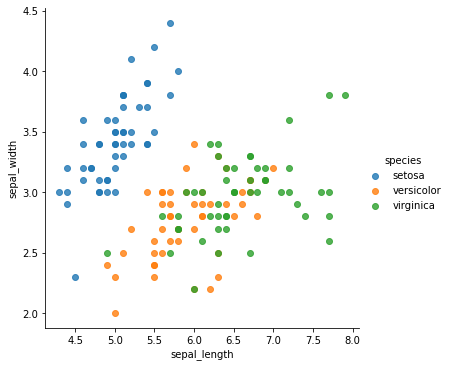

In [5]:
# plot the first two fields of the iris dataset and classify the points based on the species
# fit_reg=False indicates don't fit a regression model
# hue='species' indicates to classify the points based on the species field
sns.lmplot(data=iris,x="sepal_length",y="sepal_width",hue='species',fit_reg=False) 

Since this is a multiclass classification problem, we need to convert the label column to binary columns. This is known as one-hot encoding. The routine `pd.get_dummies()` converts the `iris.species` field, which has three values, to three binary columns where the names of the columns are the same as the categorical values. Once we create these columns they can be joined to the original dataset.

In [6]:
dummies = pd.get_dummies(iris.species) # one-hot encoding
dummies.head()

,setosa,versicolor,virginica
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


In [7]:
iris = iris.join(dummies) # join the binary columns to the original dataset
iris.describe() # show the statistics of the numerical features of the dataframe

,sepal_length,sepal_width,petal_length,petal_width,setosa,versicolor,virginica
count,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,0.333333,0.333333,0.333333
std,0.828066,0.435866,1.765298,0.762238,0.472984,0.472984,0.472984
min,4.300000,2.000000,1.000000,0.100000,0.000000,0.000000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000,0.000000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,0.000000,0.000000,0.000000
75%,6.400000,3.300000,5.100000,1.800000,1.000000,1.000000,1.000000
max,7.900000,4.400000,6.900000,2.500000,1.000000,1.000000,1.000000


In [8]:
iris

,sepal_length,sepal_width,petal_length,petal_width,species,setosa,versicolor,virginica
0,5.1,3.5,1.4,0.2,setosa,1,0,0
1,4.9,3.0,1.4,0.2,setosa,1,0,0
2,4.7,3.2,1.3,0.2,setosa,1,0,0
3,4.6,3.1,1.5,0.2,setosa,1,0,0
4,5.0,3.6,1.4,0.2,setosa,1,0,0
...,...,...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica,0,0,1
146,6.3,2.5,5.0,1.9,virginica,0,0,1
147,6.5,3.0,5.2,2.0,virginica,0,0,1
148,6.2,3.4,5.4,2.3,virginica,0,0,1


Now we create a features table XX which comprises the first four columns of the iris data set, and a target series Y which is the binary column we have just created to identify whether or not the species is versicolor. As we will use regularization, we will use the normalized version of the features matrix X.

In [9]:
# the table XX will have the first 3 columns (0 to 3) of iris, and Y will have the binary classification column
XX, Y = iris[iris.columns[:4]], iris.versicolor 
X = (XX-XX.mean())/XX.std() # create a new feature matrix for analysis which has mean 0 and standard deviation 1

In [10]:
X

,sepal_length,sepal_width,petal_length,petal_width
0,-0.897674,1.015602,-1.335752,-1.311052
1,-1.139200,-0.131539,-1.335752,-1.311052
2,-1.380727,0.327318,-1.392399,-1.311052
3,-1.501490,0.097889,-1.279104,-1.311052
4,-1.018437,1.245030,-1.335752,-1.311052
...,...,...,...,...
145,1.034539,-0.131539,0.816859,1.443994
146,0.551486,-1.278680,0.703564,0.919223
147,0.793012,-0.131539,0.816859,1.050416
148,0.430722,0.786174,0.930154,1.443994


Then we split these data sets into training and testing sets.

In [11]:
from sklearn.model_selection import train_test_split # import the splitting method from sklearn

# split the data into 80% training and 20% testing, random_state=0 ensures that the results are repeatable
X_train,X_test,y_train,y_test=train_test_split(X,Y,train_size=0.8,random_state=0)  

In [12]:
X

,sepal_length,sepal_width,petal_length,petal_width
0,-0.897674,1.015602,-1.335752,-1.311052
1,-1.139200,-0.131539,-1.335752,-1.311052
2,-1.380727,0.327318,-1.392399,-1.311052
3,-1.501490,0.097889,-1.279104,-1.311052
4,-1.018437,1.245030,-1.335752,-1.311052
...,...,...,...,...
145,1.034539,-0.131539,0.816859,1.443994
146,0.551486,-1.278680,0.703564,0.919223
147,0.793012,-0.131539,0.816859,1.050416
148,0.430722,0.786174,0.930154,1.443994


In [13]:
Y

0      0
1      0
2      0
3      0
4      0
      ..
145    0
146    0
147    0
148    0
149    0
Name: versicolor, Length: 150, dtype: uint8

## Logistic Regression

We can now introduce the sigmoid or logistic function. This is a defined as

$$ f(x) = \displaystyle{\frac{1}{1+e^{-x}}}, $$

and is a smooth, one-to-one (every x value gives a unique y value) function with the domain $(-\infty,\infty)$ and range $(0,1)$. If x is negative then the logistic function is less than 0.5 but greater than 0, while if x is positive the logistic function is greater than 0.5 but less than 1.

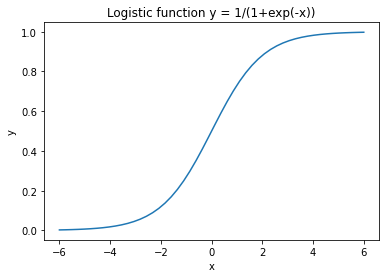

In [14]:
xa = np.linspace(-6,6) # create a linear array of x values between -6 and 6
plt.plot(xa,1/(1+np.exp(-xa))); # plot the logistic function 
plt.xlabel("x") # xlabel
plt.ylabel("y") # ylabel
plt.title("Logistic function y = 1/(1+exp(-x))"); # title

Logistic regression assumes that the data is described by m instances or points, and at each of these there are n features. At each point from i=1,2,...,m, the probability of the data being classified as true or false is modelled by

$$ y_i = f(c_0 + c_1 x_{i,1} + c_2 x_{i,2} + \cdots + c_n x_{i,n}), $$

where $f$ is the **logistic** function. The algorithm then calculates the optimal coefficients $c_1$, $c_2$,..., $c_n$ and the intercept $c_0$. For linear regression the coefficients were calculated by minimizing the sum of the square of the errors. This is equivalent to maximimizing the likelihood of the observed data, assuming the data points are distributed with mean 0 and some standard deviation $\sigma$. Therefore, the observed data is the most likely data. For logistic regression these two statements are no longer equivalent, however, the coefficients can be calculated by again maximizing the likelihood of the observed data. This is done by using optimization algorithms.

The process for logistic regression using `sklearn` is the same as the other models we have so far considered, however the options change when instantiating the model. We will use the default solver `lbfgs` and no regularization, which corresponds to `penalty='none'`. We can then fit the data and show the model partameters.

In [15]:
from sklearn.linear_model import LogisticRegression # import the LogisticRegression model
# instantiate the model (using the default parameters)
# penalty='none' implies no regularization and solver='lbfgs' is the default solver
# different solvers can be used, dependent on the type of penalties that are implemented
logreg = LogisticRegression(solver='lbfgs',penalty='none')
logreg.fit(X_train,y_train) # fit the training data to the model
print('Model coefficients are',np.round(logreg.coef_,3)) # print the model coefficients c1,...,c4
print('Model intercept is',np.round(logreg.intercept_,3)) # print the model intercept c0

Model coefficients are [[-0.728 -1.04   3.269 -2.612]]
Model intercept is [-1.139]


Next we investigate the probabilities that are output. The second column, which is the probability of correctly picking the species, is the output of the logistic function. Since the problem is binary, the first column is just 1 minus the second column. 

In [16]:
y_preda = logreg.predict_proba(X_test) # calculate the probabilities for the test features
# print out the probability table with a header
print('Probability table for testing set is:')
print(y_preda)

Probability table for testing set is:
[[0.89243578 0.10756422]
 [0.13005863 0.86994137]
 [0.98909241 0.01090759]
 [0.35327204 0.64672796]
 [0.87792911 0.12207089]
 [0.91870274 0.08129726]
 [0.94905456 0.05094544]
 [0.78248685 0.21751315]
 [0.53102397 0.46897603]
 [0.65646548 0.34353452]
 [0.07941501 0.92058499]
 [0.8355475  0.1644525 ]
 [0.27061832 0.72938168]
 [0.63956782 0.36043218]
 [0.48313743 0.51686257]
 [0.90068995 0.09931005]
 [0.63590785 0.36409215]
 [0.1914039  0.8085961 ]
 [0.7974158  0.2025842 ]
 [0.98978748 0.01021252]
 [0.7190421  0.2809579 ]
 [0.6093423  0.3906577 ]
 [0.74197751 0.25802249]
 [0.60756692 0.39243308]
 [0.72457132 0.27542868]
 [0.95367092 0.04632908]
 [0.9507414  0.0492586 ]
 [0.60314947 0.39685053]
 [0.22360126 0.77639874]
 [0.92223402 0.07776598]]


Using a classification threshold of 0.5, i.e., $P>0.5$ indicates true and $P<0.5$ indicates false, the probabilities are then used to predict the target test values, which can be compared against the actual target test values. We can see there are correct predictions at (1,1) (true positives) and (0,0) (true negative), but there are also false positives at (1,0) and false negatives at (0,1). False positives indicates that the model incorrectly predicts a positive value, similarly false negatives indicates that the model incorrectly predicts a negative value.

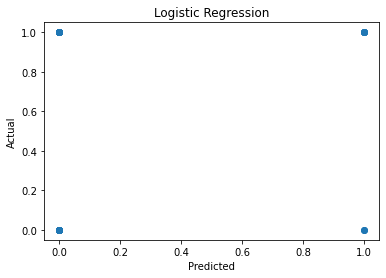

In [17]:
y_pred=logreg.predict(X_test) # calculate the predicted values of the model for the test features
plt.scatter(y_pred,y_test) # plot the predicted values against the actual test values
plt.xlabel('Predicted') # xlabel
plt.ylabel('Actual') # ylabel 
plt.title('Logistic Regression'); # add a title

To determine the number of correct predictions, false positives and false negatives, we can construct a confusion matrix. From the confusion matrix it can be seen that there are 15 true negatives, 5 true positives, 2 false positives where versicolor was incorrectly predicted, and 8 false negatives, where the other species was incorrectly predicted. The false positive and negatives will typically relate to the virginica species, rather than setosa.

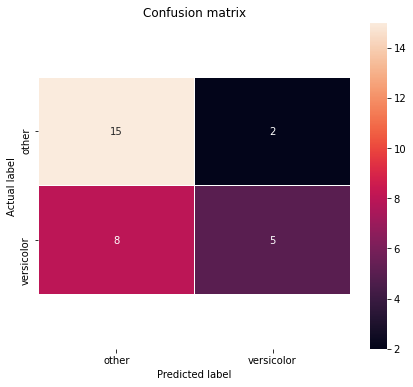

In [18]:
from sklearn.metrics import confusion_matrix # import the confusion matrix function
cnf_matrix = confusion_matrix(y_test, y_pred) # create a confusion matrix for our actual and predicted values
# create a data frame from the confusion matrix with the column and row names being the class_names
class_names=['other', 'versicolor'] # names of the binary classes for plotting
cmatrix = pd.DataFrame(cnf_matrix,columns=class_names,index=class_names) 
f, ax = plt.subplots(figsize=(7,6)) # initialise the plots and axes
sns.heatmap(cmatrix, annot=True, linewidths=.5) # plot the confusion matrix as a heatmap
plt.title('Confusion matrix') # add a title
plt.ylabel('Actual label') # add a ylabel
plt.xlabel('Predicted label') # add a xlabel
# adjust the bottom and top of the figure, so we can view all of it
bottom, top = ax.get_ylim()  # get the y axis limits
ax.set_ylim(bottom + 0.5, top - 0.5); # adjust the y axis limits

We can calculate various scores to determine the effectiveness of the classifier. The accuracy score is the number of correct scores divided by the number of samples. The precision score is the number of true positives divided by the true positives plus false positives. The recall score is the number of true positives divided by the true positives plus false negatives. The precision and recall scores give an indication of how well the algorithm is able to pick positive samples, whereas the accurary gives an indication of how well the algorithm can predict correct samples overall.

In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score # import the score functions 
print("Accuracy:",np.round(accuracy_score(y_test, y_pred),3)) # calculate and print the accuracy score
print("Precision:",np.round(precision_score(y_test, y_pred),3)) # calculate and print the precision score
print("Recall:",np.round(recall_score(y_test, y_pred),3)) # calculate and print the recall score

Accuracy: 0.667
Precision: 0.714
Recall: 0.385


These measures, and other measures of the classification, can also be plotted by using the `sklearn` function `classification_report`. The **f1-score** is a combination of the **precision** and **recall**. This function is particularly useful for multiclass problems.

In [20]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.88      0.75        17
           1       0.71      0.38      0.50        13

    accuracy                           0.67        30
   macro avg       0.68      0.63      0.62        30
weighted avg       0.68      0.67      0.64        30



To further quantify the accurary of the classifier we can construct a Response Operating Characteristic (ROC) curve, which plots the false positive rate (FPR) against the true positive rate (TPR) as the classification threshold is changed. The TPR is the same as the precision score, while the FPR is the number of false positives divided by the false positives plus true negatives. For a perfect classifier we would expect that TPR=1 and FPR=0. We have considered up until this point a classification threshold of 0.5. If the classification threshold is very high (close to 1), then we are not going to flag any positive respones, so TPR=0 and FPR=0. If the classification threshold is very low (close to 0), then we will only flag positive responses and TPR=1 and FPR=1. Hence if our classifier is good, as the threshold changes the ROC curve will hug the left and top boundaries of the figure. If this occurs the area under the ROC curve (AUC) will approach 1. Therefore classifiers can be compared for a particular problem by measuring the AUC. Any classifier which is below the line y=x and has AUC less than 0.5 will be useless. 

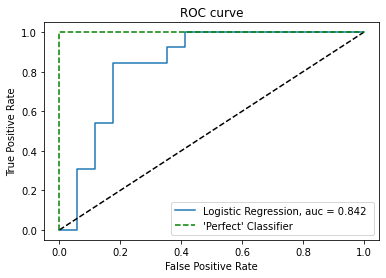

In [21]:
# import the functions to calculate the parameters for the ROC curve and the AUC
from sklearn.metrics import roc_curve, roc_auc_score 
y_pred_proba = logreg.predict_proba(X_test)[::,1] # extract the second column of the model probabilities 
# calculate the false positive and true positive rates as the threshold is varied, we don't use thresholds
fpr, tpr, thresholds = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba) # calculate the area under the ROC curve (AUC)
# plot the FPR vs TPR and format label with AUC to 3 decimal places
plt.plot(fpr,tpr,label="Logistic Regression, auc = %0.3f " % auc)
plt.plot([0,1],[0,1],'k--') # plot x = y for comparison
plt.plot([0, 0, 1], [0, 1, 1], 'g--', label="'Perfect' Classifier")
plt.xlabel('False Positive Rate') # add xlabel
plt.ylabel('True Positive Rate') # add ylabel
plt.title('ROC curve') # add title
plt.legend(loc='best'); # add legend

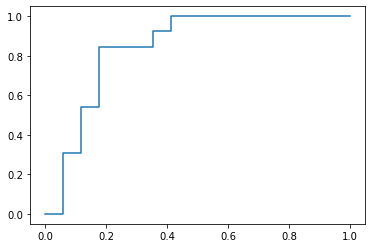

In [22]:
plt.plot(fpr,tpr,label="Logistic Regression, auc = %0.3f " % auc)

## Ridge regularization

As with Linear Regression we can use regularization on Logistic Regression to improve the accuracy of the model. Here we will only consider Ridge regularization. For Logistic Regression, Ridge regularization is implemented by setting `penalty='l2'` and the regularization is inversely proportional to the parameter C, which has the default value 1. Therefore C very large corresponds to no regularization. In the following we calculate the ROC curve and the corresponding AUC for C=1 and 5. As is apparent we obtain an increase in the AUC with C=5.

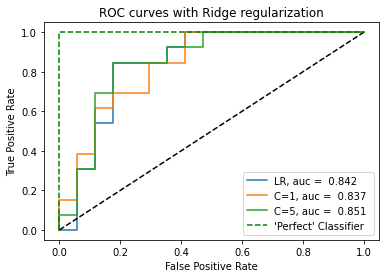

In [23]:
plt.plot(fpr,tpr,label="LR, auc =  %0.3f " % auc) # original model with no regularization #infinite penalty#c=0, alpha becomes very large

for CC in  [1.,5.]:
# instantiate the logistic regression model with ridge regularization and C=CC
    logreg1 = LogisticRegression(solver='lbfgs',penalty='l2',C=CC) 
    logreg1.fit(X_train,y_train) # fit the data to the model
    y_pred = logreg1.predict(X_test) # calculate the probabilites for the test features
    y_pred_proba = logreg1.predict_proba(X_test)[::,1] # calculate the probabilites for the test features
    fpr1, tpr1, thresholds1 = roc_curve(y_test,  y_pred_proba) # calculate the FPR and TPR for the ROC curve
    auc1 = roc_auc_score(y_test, y_pred_proba) # calculate the area under the ROC curve
    plt.plot(fpr1,tpr1,label="C={:.0f}, auc =  {:.3f} ".format(CC,auc1)) # regularization with given value of C

# plot the ROC curves for the three models
plt.plot([0,1],[0,1],'k--') # plot x = y for comparision
plt.plot([0, 0, 1], [0, 1, 1], 'g--', label="'Perfect' Classifier")
plt.xlabel('False Positive Rate') # add xlabel
plt.ylabel('True Positive Rate') # add ylabel
plt.title('ROC curves with Ridge regularization') # add title
plt.legend(loc='best'); # add legend

## Exercise

The aim of this exercise is to construct a simple one vs rest multiclass classifier based on the probabilities for each of the binary problems for the three iris species. For this problem, only use the first two features, i.e., sepal width and sepal length. 

**Exercise 1** 

Create a new features dataframe only using the first two columns of the iris features. (2 marks)

In [66]:
load_iris=sns.load_dataset('iris')
create_iris=load_iris[load_iris.columns[0:2]]
norm_create_iris=(create_iris-create_iris.mean())/create_iris.std()
norm_create_iris


,sepal_length,sepal_width
0,-0.897674,1.015602
1,-1.139200,-0.131539
2,-1.380727,0.327318
3,-1.501490,0.097889
4,-1.018437,1.245030
...,...,...
145,1.034539,-0.131539
146,0.551486,-1.278680
147,0.793012,-0.131539
148,0.430722,0.786174


**Exericse 2** 

For each of the iris categories, model the data using Logistic Regression with C=5 for Ridge Regularization and calculate the probabilities for the testing set of the category being correct. Store these probabilites in an array. For each category you will need to resplit the data set, but make sure you use the same random state. Alternatively, split the data set initially with all three labels, and then work on each category. The necessary one-hot encoding has already been performed. (3 marks)

In [69]:
setosa_Y=iris.setosa
s_X_train,s_X_test,s_y_train,s_y_test=train_test_split(create_iris,setosa_Y,train_size=0.8,random_state=0) 
from sklearn.linear_model import LogisticRegression # import the LogisticRegression model
# instantiate the model (using the default parameters)
# penalty='none' implies no regularization and solver='lbfgs' is the default solver
# different solvers can be used, dependent on the type of penalties that are implemented
logreg = LogisticRegression(solver='lbfgs',penalty='none')
logreg.fit(s_X_train,s_y_train) # fit the training data to the model
print('Model coefficients setosa are',np.round(logreg.coef_,3)) # print the model coefficients c1,...,c4
print('Model intercept setosa is',np.round(logreg.intercept_,3)) # print the model intercept c0
s_y_preda = logreg.predict_proba(s_X_test) # calculate the probabilities for the setosa
# print out the probability table with a header
print('Probability table for testing set setosa is:')
print(s_y_preda)
setosa_y_preda= s_y_preda[:,1]
prob_setosa={"setosa":list(s_y_preda[:,1])}
prob_setosa

Model coefficients setosa are [[-132.357  140.726]]
Model intercept setosa is [282.231]
Probability table for testing set setosa is:
[[1.00000000e+000 2.00573705e-040]
 [1.00000000e+000 1.36736359e-088]
 [0.00000000e+000 1.00000000e+000]
 [1.00000000e+000 1.55202168e-120]
 [0.00000000e+000 1.00000000e+000]
 [1.00000000e+000 1.31698572e-038]
 [0.00000000e+000 1.00000000e+000]
 [1.00000000e+000 8.00648902e-074]
 [1.00000000e+000 6.61069499e-098]
 [1.00000000e+000 1.14199955e-057]
 [1.00000000e+000 6.82869524e-070]
 [1.00000000e+000 1.81850407e-050]
 [1.00000000e+000 1.14199955e-057]
 [1.00000000e+000 1.16106139e-080]
 [1.00000000e+000 1.47682840e-051]
 [0.00000000e+000 1.00000000e+000]
 [1.00000000e+000 8.27051823e-046]
 [1.00000000e+000 2.10646311e-035]
 [0.00000000e+000 1.00000000e+000]
 [0.00000000e+000 1.00000000e+000]
 [1.00000000e+000 6.29041607e-029]
 [1.00000000e+000 1.05198022e-016]
 [0.00000000e+000 1.00000000e+000]
 [0.00000000e+000 1.00000000e+000]
 [1.00000000e+000 2.0392160

{'setosa': [2.005737050783405e-40,
  1.367363594313124e-88,
  1.0,
  1.5520216777408002e-120,
  1.0,
  1.3169857198749991e-38,
  1.0,
  8.006489015086827e-74,
  6.610694993330959e-98,
  1.1419995530120415e-57,
  6.828695241209568e-70,
  1.818504067245492e-50,
  1.1419995530120415e-57,
  1.1610613896109335e-80,
  1.4768283999513496e-51,
  1.0,
  8.270518227096158e-46,
  2.106463106914475e-35,
  1.0,
  1.0,
  6.290416074457224e-29,
  1.0519802233871364e-16,
  1.0,
  1.0,
  2.0392160760785868e-63,
  1.0,
  1.0,
  2.6371045477619857e-57,
  5.36506504060896e-25,
  1.0]}

In [70]:
X_train,X_test,y_train,y_test=train_test_split(create_iris,Y,train_size=0.8,random_state=0)  
from sklearn.linear_model import LogisticRegression # import the LogisticRegression model
# instantiate the model (using the default parameters)
# penalty='none' implies no regularization and solver='lbfgs' is the default solver
# different solvers can be used, dependent on the type of penalties that are implemented
logreg = LogisticRegression(solver='lbfgs',penalty='none')
logreg.fit(X_train,y_train) # fit the training data to the model
print('Model coefficients versicolor are',np.round(logreg.coef_,3)) # print the model coefficients c1,...,c4
print('Model intercept versicolor is',np.round(logreg.intercept_,3)) # print the model intercept c0
ver_y_preda = logreg.predict_proba(X_test) # calculate the probabilities for the versicolor
# print out the probability table with a header
print('Probability table for testing set versicolor is:')
print(ver_y_preda)
versicolor_y_preda= ver_y_preda[:,1]
prob_versicolor={"versicolor":list(ver_y_preda[:,1])}
prob_versicolor


Model coefficients versicolor are [[-0.031 -3.094]]
Model intercept versicolor is [8.548]
Probability table for testing set versicolor is:
[[0.57285767 0.42714233]
 [0.17412141 0.82587859]
 [0.9902028  0.0097972 ]
 [0.65679456 0.34320544]
 [0.89333646 0.10666354]
 [0.8648145  0.1351855 ]
 [0.91943375 0.08056625]
 [0.77719241 0.22280759]
 [0.58036499 0.41963501]
 [0.57511356 0.42488644]
 [0.42164043 0.57835957]
 [0.82484845 0.17515155]
 [0.57511356 0.42488644]
 [0.57811653 0.42188347]
 [0.64842877 0.35157123]
 [0.93940288 0.06059712]
 [0.6477274  0.3522726 ]
 [0.41714757 0.58285243]
 [0.70714469 0.29285531]
 [0.97550666 0.02449334]
 [0.57135206 0.42864794]
 [0.71221335 0.28778665]
 [0.89274899 0.10725101]
 [0.63642053 0.36357947]
 [0.57586483 0.42413517]
 [0.93887558 0.06112442]
 [0.96662282 0.03337718]
 [0.64912949 0.35087051]
 [0.2178819  0.7821181 ]
 [0.89333646 0.10666354]]


{'versicolor': [0.42714232599224516,
  0.825878589605621,
  0.00979719521611631,
  0.3432054412519288,
  0.1066635401636379,
  0.13518550395877835,
  0.08056625361777277,
  0.22280758890519992,
  0.4196350093474747,
  0.42488643975023277,
  0.5783595671856189,
  0.17515155333489715,
  0.42488643975023277,
  0.4218834668967182,
  0.35157123274065244,
  0.06059711529249458,
  0.35227259925982973,
  0.5828524299448086,
  0.29285531492137173,
  0.024493339426152252,
  0.42864794161032793,
  0.28778665093267375,
  0.10725100661402899,
  0.36357947486456005,
  0.4241351675464534,
  0.06112441506661347,
  0.033377178507366524,
  0.35087050620098187,
  0.7821181036654125,
  0.1066635401636379]}

In [71]:
virginica_Y=iris.virginica
v_X_train,v_X_test,v_y_train,v_y_test=train_test_split(create_iris,virginica_Y,train_size=0.8,random_state=0)
from sklearn.linear_model import LogisticRegression # import the LogisticRegression model
# instantiate the model (using the default parameters)
# penalty='none' implies no regularization and solver='lbfgs' is the default solver
# different solvers can be used, dependent on the type of penalties that are implemented
logreg = LogisticRegression(solver='lbfgs',penalty='none')
logreg.fit(v_X_train,v_y_train) # fit the training data to the model
print('Model coefficients virginica are',np.round(logreg.coef_,3)) # print the model coefficients c1,...,c4
print('Model intercept virginica is',np.round(logreg.intercept_,3)) # print the model intercept c0
v_y_preda = logreg.predict_proba(v_X_test) # calculate the probabilities for the virginica
# print out the probability table with a header
print('Probability table for testing set virginica is:')
print(v_y_preda)
virginica_y_preda=v_y_preda[:,1]
prob_virginica={"virginica":list(v_y_preda[:,1])}
prob_virginica

Model coefficients virginica are [[ 2.904 -0.832]]
Model intercept virginica is [-15.623]
Probability table for testing set virginica is:
[[0.75197666 0.24802334]
 [0.5072939  0.4927061 ]
 [0.95871834 0.04128166]
 [0.0405529  0.9594471 ]
 [0.98076572 0.01923428]
 [0.51827398 0.48172602]
 [0.98227399 0.01772601]
 [0.22185273 0.77814727]
 [0.14247248 0.85752752]
 [0.55920997 0.44079003]
 [0.51788251 0.48211749]
 [0.42544061 0.57455939]
 [0.55920997 0.44079003]
 [0.284209   0.715791  ]
 [0.57960553 0.42039447]
 [0.98773232 0.01226768]
 [0.64829725 0.35170275]
 [0.85984614 0.14015386]
 [0.98492704 0.01507296]
 [0.96030379 0.03969621]
 [0.84422413 0.15577587]
 [0.86487627 0.13512373]
 [0.98914759 0.01085241]
 [0.99482178 0.00517822]
 [0.48688993 0.51311007]
 [0.99482985 0.00517015]
 [0.98154916 0.01845084]
 [0.50768579 0.49231421]
 [0.95331233 0.04668767]
 [0.98076572 0.01923428]]


{'virginica': [0.2480233422728682,
  0.4927060995470329,
  0.04128165880892984,
  0.9594471014103405,
  0.01923428465828628,
  0.481726020082402,
  0.017726011206130474,
  0.7781472729070973,
  0.8575275191593488,
  0.44079003212167944,
  0.48211748623786593,
  0.574559385206502,
  0.44079003212167944,
  0.7157910034485834,
  0.420394469516419,
  0.012267677921243043,
  0.3517027500945227,
  0.14015385687413598,
  0.015072961745897034,
  0.039696207991861215,
  0.15577586844740413,
  0.13512373002537154,
  0.010852407303928837,
  0.005178221878359642,
  0.5131100721437897,
  0.005170151174826152,
  0.01845084058976398,
  0.4923142089175486,
  0.046687673760562695,
  0.01923428465828628]}

In [73]:
index= X_test.index.tolist()
vir_df=pd.DataFrame(prob_virginica,index=index)
ver_df=pd.DataFrame(prob_versicolor,index=index)
set_df=pd.DataFrame(prob_setosa,index=index)
final= pd.concat([vir_df,ver_df,set_df],axis=1)
final


,virginica,versicolor,setosa
114,0.248023,0.427142,2.005737e-40
62,0.492706,0.825879,1.367364e-88
33,0.041282,0.009797,1.000000e+00
107,0.959447,0.343205,1.552022e-120
7,0.019234,0.106664,1.000000e+00
100,0.481726,0.135186,1.316986e-38
40,0.017726,0.080566,1.000000e+00
86,0.778147,0.222808,8.006489e-74
76,0.857528,0.419635,6.610695e-98
71,0.440790,0.424886,1.142000e-57


In [49]:
vir_df=pd.DataFrame(prob_virginica).rename(columns={0: "virginica"})
ver_df=pd.DataFrame(prob_versicolor).rename(columns={0: "versicolor"})
set_df=pd.DataFrame(prob_setosa).rename(columns={0: "setosa"})

In [53]:
total=[vir_df,ver_df,set_df]
result = pd.concat(total,axis=1)
result



,virginica,versicolor,setosa
0,0.248023,0.427142,2.005737e-40
1,0.492706,0.825879,1.367364e-88
2,0.041282,0.009797,1.000000e+00
3,0.959447,0.343205,1.552022e-120
4,0.019234,0.106664,1.000000e+00
5,0.481726,0.135186,1.316986e-38
6,0.017726,0.080566,1.000000e+00
7,0.778147,0.222808,8.006489e-74
8,0.857528,0.419635,6.610695e-98
9,0.440790,0.424886,1.142000e-57


**Exercise 3** 

For each instance in feature space, choose the category with the highest probability. The function `numpy.argmax()` will be allow you to do this. (3 marks)

In [77]:
prob=[]
for i in range(0,30):
    prob=prob+[[versicolor_y_preda[i],virginica_y_preda[i],setosa_y_preda[i]]]
predicted_species=list(np.argmax(prob,axis=1))
predicted_species=['versicolor' if i==0 else i for i in predicted_species]
predicted_species=['virginica' if i==1 else i for i in predicted_species]
predicted_species=['setosa' if i==2 else i for i in predicted_species]
predicted_species={'predicted_species':predicted_species}
df_p_s=pd.DataFrame(predicted_species,index=index)
df_p_s



,predicted_species
114,versicolor
62,versicolor
33,setosa
107,virginica
7,setosa
100,virginica
40,setosa
86,virginica
76,virginica
71,virginica


**Exercise 4** 

Plot the final classification for the testing set in feature space, with colours based on the predicted category. (2 marks)

In [78]:
final_df=pd.concat([X_test,df_p_s],axis=1)
final_df



,sepal_length,sepal_width,predicted_species
114,5.8,2.8,versicolor
62,6.0,2.2,versicolor
33,5.5,4.2,setosa
107,7.3,2.9,virginica
7,5.0,3.4,setosa
100,6.3,3.3,virginica
40,5.0,3.5,setosa
86,6.7,3.1,virginica
76,6.8,2.8,virginica
71,6.1,2.8,virginica


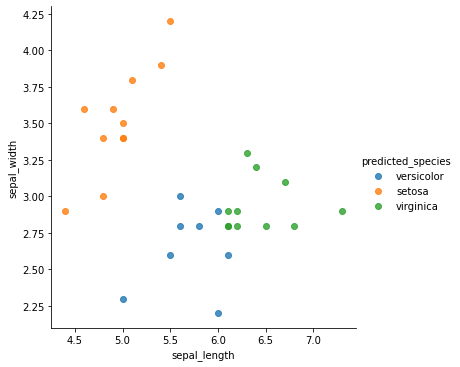

In [80]:
sns.lmplot(data=final_df,x="sepal_length",y="sepal_width",hue="predicted_species",fit_reg=False)